# Data gathering 

All data from 2001 March onwards on a monthly basis

The output variable is UK CPI inflation data.

The input variables are GDP growth, Total pay growth(nominal), UK interest rate, Unemployment rate, USD/GBP rate

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm

### CPI data

In [2]:
monthly_data = pd.read_csv("UK CPI data.csv", skiprows=list(range(1, 329)) + [603])
monthly_data.columns = ['Year and Month', 'CPI']
monthly_data['Year and Month'] = pd.to_datetime(monthly_data['Year and Month'], format='%Y %b')
#print(monthly_data)

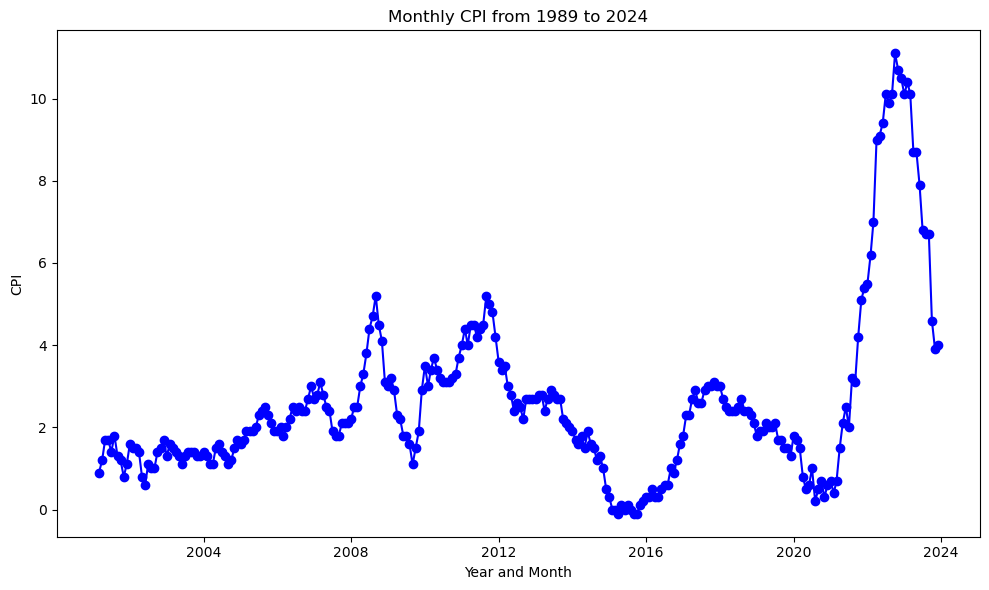

In [3]:
plt.figure(figsize=(10, 6))  # Setting the figure size
plt.plot(monthly_data['Year and Month'], monthly_data['CPI'], marker='o', linestyle='-', color='b')  # Plot with markers and a line
plt.title('Monthly CPI from 1989 to 2024')  # Title of the plot
plt.xlabel('Year and Month')  # X-axis label
plt.ylabel('CPI')  # Y-axis label
#plt.xticks(rotation=45)  # Rotate x-axis labels to avoid overlap
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

### GDP data

In [4]:
gdp_quarterly_data = pd.read_csv("GDP quarterly.csv", skiprows=range(1, 175))
gdp_quarterly_data.columns = ['Date', 'GDP growth']

def quarter_to_datetime(quarter_str):
    year, qtr = quarter_str.split(' ')
    qtr_month_map = {'Q1': '01', 'Q2': '04', 'Q3': '07', 'Q4': '10'}
    return pd.to_datetime(f"{year}-{qtr_month_map[qtr]}-01")

# Apply the function to the 'Date' column
gdp_quarterly_data['Date'] = gdp_quarterly_data['Date'].apply(quarter_to_datetime)


# Generate monthly dates from January 1997 to December 2023
monthly_dates = pd.date_range(start='2001-03-01', end='2023-12-31', freq='MS')

# Create a new DataFrame for monthly data
monthly_gdp_data = pd.DataFrame({'Date': monthly_dates})

# Use 'forward fill' to assign quarterly GDP growth rates to each month within the quarter
# First, ensure monthly_gdp_data['Date'] is also in a compatible format for merging
monthly_gdp_data['Date'] = pd.to_datetime(monthly_gdp_data['Date'])

monthly_gdp_data = pd.merge_asof(monthly_gdp_data.sort_values('Date'), gdp_quarterly_data.sort_values('Date'), on='Date', direction='forward')

monthly_gdp_data['GDP growth'] = monthly_gdp_data['GDP growth'].shift(2) 

monthly_gdp_data.loc[0:1, 'GDP growth'] = 1.6

monthly_gdp_data


,Date,GDP growth
0,2001-03-01,1.6
1,2001-04-01,1.6
2,2001-05-01,0.4
3,2001-06-01,0.4
4,2001-07-01,0.5
...,...,...
269,2023-08-01,-0.1
270,2023-09-01,-0.1
271,2023-10-01,-0.3
272,2023-11-01,-0.3


### Total pay nominal

In [5]:
total_pay_nominal = pd.read_csv("Total pay nominal.csv").iloc[:, :-3]
#total_pay_nominal 


### Interest rate data

In [6]:
interest_rate_data = pd.read_csv("UK interest rate.csv")
interest_rate_data['Date Changed'] = pd.to_datetime(interest_rate_data['Date Changed'], format='%d %b %y').apply(lambda x: x.replace(day=1))

# Drop duplicates for the 1st of each month and sort
interest_rate_data = interest_rate_data.drop_duplicates('Date Changed').sort_values('Date Changed')

# Generate monthly dates from the earliest date in data to December 1, 2023
all_dates = pd.date_range(start=interest_rate_data['Date Changed'].min(), end='2023-12-01', freq='MS')

# Merge the full date range with the original data, forward filling the rates
full_interest_rate = pd.merge_asof(pd.DataFrame(all_dates, columns=['Date Changed']), interest_rate_data, on='Date Changed')

# Fill any missing rates after the last known rate change with 5.25%
full_interest_rate['Rate'].fillna(5.25, inplace=True)

# Filter for entries from 1997 onwards
monthly_interest_rate_1997 = full_interest_rate[full_interest_rate['Date Changed'] >= '2001-03-01'].reset_index(drop=True)

monthly_interest_rate_1997

,Date Changed,Rate
0,2001-03-01,5.75
1,2001-04-01,5.50
2,2001-05-01,5.25
3,2001-06-01,5.25
4,2001-07-01,5.25
...,...,...
269,2023-08-01,5.25
270,2023-09-01,5.25
271,2023-10-01,5.25
272,2023-11-01,5.25


### Unemployment data

In [7]:
unemployment_data = pd.read_csv("Unemployment data.csv", skiprows=range(1,634))

unemployment_data.loc[273, 'Unemployment rate (aged 16 and over, seasonally adjusted): %'] = 3.8

#unemployment_data


### USD GBP exchange data 

In [8]:
USDGBP = pd.read_csv("USD GBP exchange monthly.csv", skiprows=range(1,861))

#USDGBP

### M3 money supply

In [9]:
m3_data = pd.read_csv('M3 money supply.csv').iloc[::-1].reset_index(drop=True)

#m3_data 

### Brent

In [10]:
brent_data = pd.read_csv('Brent monthly.csv', skiprows=list(range(1, 7)) + list(range(281, 447))).iloc[::-1].reset_index(drop=True)

brent_data 

,Europe Brent Spot Price FOB
0,24.50
1,25.66
2,28.31
3,27.85
4,24.61
...,...
269,86.15
270,93.72
271,90.60
272,82.94


In [11]:
monthly_data['Interest rate'] = monthly_interest_rate_1997['Rate']
monthly_data['GDP growth'] = monthly_gdp_data['GDP growth']
monthly_data['Total pay nominal'] = total_pay_nominal['Total pay (nominal)']
monthly_data['Unemployment'] = unemployment_data['Unemployment rate (aged 16 and over, seasonally adjusted): %']
monthly_data['USD/GBP'] = USDGBP['Average Sterling exchange rate: US Dollar XUMAUSS']
monthly_data['M3 growth'] = m3_data['Monthly 1 month growth rate of monetary financial institutions\' sterling and all foreign currency M3 (UK estimate of EMU aggregate) liabilities to private and public sectors (in percent) seasonally adjusted                          LPMVWYP']
monthly_data['Brent'] = brent_data['Europe Brent Spot Price FOB']
monthly_data 


,Year and Month,CPI,Interest rate,GDP growth,Total pay nominal,Unemployment,USD/GBP,M3 growth,Brent
0,2001-03-01,0.9,5.75,1.6,6.1,5.0,1.4454,2.5,24.50
1,2001-04-01,1.2,5.50,1.6,6.2,4.9,1.4350,0.6,25.66
2,2001-05-01,1.7,5.25,0.4,5.1,5.0,1.4259,0.1,28.31
3,2001-06-01,1.7,5.25,0.4,5.5,5.0,1.4014,0.5,27.85
4,2001-07-01,1.4,5.25,0.5,5.2,5.1,1.4139,1.2,24.61
...,...,...,...,...,...,...,...,...,...
269,2023-08-01,6.7,5.25,-0.1,8.2,4.1,1.2707,0.4,86.15
270,2023-09-01,6.7,5.25,-0.1,8.0,4.0,1.2389,-0.4,93.72
271,2023-10-01,4.6,5.25,-0.3,7.2,3.9,1.2168,-0.9,90.60
272,2023-11-01,3.9,5.25,-0.3,6.7,3.8,1.2430,0.8,82.94


In [13]:
#monthly_data['12 Month MA / Current Inflation'] = abs(monthly_data['CPI'].rolling(window=12).mean() / monthly_data['CPI'])
monthly_data['12 Month MA - current'] = monthly_data['CPI'].rolling(window=12).mean() - monthly_data['CPI']
monthly_data.to_csv('Monthly_data.csv', index=False)
monthly_data 

,Year and Month,CPI,Interest rate,GDP growth,Total pay nominal,Unemployment,USD/GBP,M3 growth,Brent,12 Month MA - current
0,2001-03-01,0.9,5.75,1.6,6.1,5.0,1.4454,2.5,24.50,NaN
1,2001-04-01,1.2,5.50,1.6,6.2,4.9,1.4350,0.6,25.66,NaN
2,2001-05-01,1.7,5.25,0.4,5.1,5.0,1.4259,0.1,28.31,NaN
3,2001-06-01,1.7,5.25,0.4,5.5,5.0,1.4014,0.5,27.85,NaN
4,2001-07-01,1.4,5.25,0.5,5.2,5.1,1.4139,1.2,24.61,NaN
...,...,...,...,...,...,...,...,...,...,...
269,2023-08-01,6.7,5.25,-0.1,8.2,4.1,1.2707,0.4,86.15,2.616667
270,2023-09-01,6.7,5.25,-0.1,8.0,4.0,1.2389,-0.4,93.72,2.333333
271,2023-10-01,4.6,5.25,-0.3,7.2,3.9,1.2168,-0.9,90.60,3.891667
272,2023-11-01,3.9,5.25,-0.3,6.7,3.8,1.2430,0.8,82.94,4.025000
